# Neural Ordinary Differential Equations

很多过程都可以用微分方程来描述：比如物理系统的演变、病人的医疗状况、市场的基本属性等。这类数据在本质上是连续的序列数据，也就是说，观测结果仅仅是某种持续变化状态的现实化。

还有另一种类型的序列数据是离散的，例如 NLP 数据：其状态的变化是离散的，从一个符号到另一个符号，从一个词到另一个词。

如今，这两类数据通常都使用递归神经网络进行处理。然而，它们在本质上是不同的，似乎应该区别对待。

在上一届 NIPS 会议上，一篇非常有趣的[论文](https://arxiv.org/abs/1806.07366)试图解决这个问题。作者提出了一种非常有前途的方法，他们称之为**神经常微分方程**。
B站中有一个[视频](https://www.bilibili.com/video/BV1hk4y1e7ZK?t=0.3)对这篇论文进行了很好的解释，我强烈推荐大家观看。
在这里，我试图重现和总结原论文的结果，让大家更容易熟悉这个想法。我相信，在卷积和递归网络中，这种新架构可能很快就会出现在任何数据科学家的工具箱中。

设想一个问题：有一个遵循未知 ODE 的过程，沿其轨迹有一些（噪声）观测结果

$$
\frac{dz}{dt} = f(z(t), t) \tag{1}
$$
$$
\{(z_0, t_0),(z_1, t_1),...,(z_M, t_M)\} - \text{observations}
$$

是否有可能找到动态函数 $f(z,t)$的近似值 $\widehat{f}(z,t,\theta)$？

首先，我们来考虑一个更简单的任务：只有两个观测值，分别位于轨迹的起点和终点：$(z_0, t_0), (z_1, t_1)$ 。我们可以使用任何 ODE 初值求解器，通过一些参数化的动力学函数，在时间 $t_1 - t_0$ 内从 $z_0, t_0$ 开始系统的演化。在此之后，我们最终会处于某个新状态 $\hat{z_1}，t_1$，将其与观测值 $z_1$ 进行比较，并尝试通过改变参数 $\theta$来最小化差异

或者，更正式地说，考虑优化以下损失函数 $L(\hat{z_1})$：

$$
L(z(t_1)) = L \Big( z(t_0) + \int_{t_0}^{t_1} f(z(t), t, \theta)dt \Big) = L \big( \text{ODESolve}(z(t_0), f, t_0, t_1, \theta) \big) \tag{2}
$$

<img src=assets/backprop.png width=600></img>

<p style="text-align: center">Figure 1: 梯度的连续反向传播需要在时间上反向求解增强的 ODE <br /> 箭头表示用观测数据的梯度调整反向传播梯度<br />
图片来自原论文</p>

如果你不想深入研究数学，上图就能说明问题。黑色轨迹表示在前向传播过程中求解 ODE。红色箭头表示在反向传播过程中求解邻接 ODE

要优化 $L$，需要计算与参数有关的梯度：$z(t_0), t_0, t_1, \theta$。要做到这一点，我们首先要确定损耗如何取决于每时每刻的状态 $(z(t))$：
$$
a(t) = \frac{\partial L}{\partial z(t)} \tag{3}
$$
$a(t)$被称为 **伴随**，它的动态变化由另一个ODE给出，可以看作是链式法则的瞬时类似物

$$
\frac{d a(t)}{d t} = -a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} \tag{4}
$$
该公式的实际推导过程见原论文附录

这里的所有向量都被视为行向量，而原论文则同时使用列和行表示法。

然后可以计算出
$$
\frac{\partial L}{\partial z(t_0)} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} dt \tag{5}
$$

要计算与 $t$ 和 $theta$ 有关的梯度，可以把它们看作是增强状态的一部分

$$
\frac{d}{dt} \begin{bmatrix} z \\ \theta \\ t \end{bmatrix} (t) = f_{\text{aug}}([z, \theta, t]) := \begin{bmatrix} f([z, \theta, t ]) \\ 0 \\ 1 \end{bmatrix} \tag{6}
$$

因此，该增强状态的伴随状态为

$$
a_{\text{aug}} := \begin{bmatrix} a \\ a_{\theta} \\ a_t \end{bmatrix}, a_{\theta}(t) := \frac{\partial L}{\partial \theta(t)}, a_t(t) := \frac{\partial L}{\partial t(t)} \tag{7}
$$

增强动力学的梯度

$$
\frac{\partial f_{\text{aug}}}{\partial [z, \theta, t]} = \begin{bmatrix} 
\frac{\partial f}{\partial z} & \frac{\partial f}{\partial \theta} & \frac{\partial f}{\partial t} \\
0 & 0 & 0 \\
0 & 0 & 0
\end{bmatrix} \tag{8}
$$

由式 (4) 得出的伴随状态 ODE 为
$$
\frac{d a_{\text{aug}}}{dt} = - \begin{bmatrix} a\frac{\partial f}{\partial z} & a\frac{\partial f}{\partial \theta} & a\frac{\partial f}{\partial t}\end{bmatrix} \tag{9}
$$

通过求解这个联合增强型 ODE 初值问题，可以得到
$$
\frac{\partial L}{\partial z(t_0)} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} dt \tag{10}
$$

$$
\frac{\partial L}{\partial \theta} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial \theta} dt \tag{11}
$$

$$
\frac{\partial L}{\partial t_0} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial t} dt \tag{12}
$$

其中包括
$$
\frac{\partial L}{\partial t_1} = - a(t) \frac{\partial f(z(t), t, \theta)}{\partial t} \tag{13}
$$
对所有 ODESolve 参数的梯度进行补充。

梯度 (10)、(11)、(12)、(13) 可以在一次调用 ODESolve 和增强状态动力学 (9) 时计算出来。

<img src=assets/pseudocode.png width=800></img>
<div align="center">Figure from the original paper</div>

上述算法描述了利用后续观察结果对 ODE 初值问题进行梯度反向传播的过程。这种算法是神经 ODE 的核心。

如果轨迹上有许多观测数据，则需要计算后续观测数据的联合增强 ODE 动力学，在观测时间用直接梯度调整反向传播梯度，如上*图 1*所示。

# 实施

下面的代码是我自己实现的**神经 ODE**。我这样做只是为了更好地理解发生了什么。不过，它与作者[资源库](https://github.com/rtqichen/torchdiffeq)中的实际实现非常接近。这本笔记将理解所需的所有代码集中在一处，而且注释稍多一些。对于实际使用和实验，我建议使用作者的原始实现。

下面是代码，如果你感兴趣的话。

In [3]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline   
#是一个IPython魔术命令，用于在Notebook中嵌入Matplotlib图形。
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F  #F是torch.nn.functional的别名，提供了各种激活函数和损失函数。
from torch.autograd import Variable #Variable是PyTorch中的变量，用于自动求导。

use_cuda = torch.cuda.is_available() #torch.cuda.is_available()检查是否有可用的CUDA设备（如NVIDIA GPU） use_cuda是一个布尔值，表示是否使用CUDA。

执行任何常微分方程初值求解器。为简单起见，将使用欧拉 ODE 初值求解器，但任何显式或隐式方法都可以。

In [5]:
def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.05 #最大步长，这里设置为0.05。
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item()) #计算步数，通过将时间跨度除以最大步长并向上取整得到。

    h = (t1 - t0)/n_steps #实际步长，即时间跨度除以步数。
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

我们还利用几种有用的方法，以神经网络的形式实现了参数化动态函数的超类。

首先，我们需要能够扁平化函数所依赖的所有参数。

其次，需要实现一种计算增强动力的方法。这种增强动态取决于函数相对于其输入和参数的梯度。  为了避免为每个新架构手动指定这些参数，我们将使用**torch.autograd.grad**方法。

In [6]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        #这个方法用于计算函数 f 以及其关于 z、t 和模型参数的梯度
        batch_size = z.shape[0] #获取输入张量 z 的第一个维度，即批次的大小。这个值在后续处理中用于扩展梯度。
        out = self.forward(z, t) #调用当前模块的 forward 方法，传入 z 和 t，得到输出 out。在神经ODE中，这通常表示 dh(t)=f(h(t),t,θ) 的值
        a = grad_outputs #为了简化后续代码，将 grad_outputs 赋值给变量 a。
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )  #使用 torch.autograd.grad 计算 out 对输入 z、时间 t 和模型参数的梯度  *adfdp：out 对模型参数的梯度，使用 * 展开为列表。
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [ ]:
class test1(nn.Module):


下面的代码封装了 *Neural ODE* 的前向和后向传递。我们必须将其从主 ***torch.nn.Module*** 中分离出来，因为自定义后向函数不能在 Module 中实现，但可以在 ***torch.autograd.Function*** 中实现。因此，这只是一个小小的变通办法。

该函数是整个神经 ODE 方法的基础。

In [7]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF) #确保传入的参数func是一个ODEF类的实例
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

为方便起见，用 **nn.Module** 封装 ode 的联合函数。

In [8]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF) #它接收一个 func 参数，这个 func 是一个继承自 ODEF 的模型，表示 ODE 右侧的动态函数，即我们想通过神经网络拟合的微分方程。
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

# Application

## _Learning true dynamics function (proof of concept)_

作为概念验证，我们现在将测试神经 ODE 是否真的能利用采样数据还原真实的动力学函数。

为了测试这一点，我们将指定一个 ODE，对其轨迹进行演化和采样，然后将其还原。

首先，我们将测试一个简单的线性 ODE。动力学是由一个矩阵给出的。

$$
\frac{dz}{dt} = \begin{bmatrix}-0.1 & -1.0\\1.0 & -0.1\end{bmatrix} z
$$

这里的训练函数也是一个简单的矩阵。

这里的训练函数也是一个简单的矩阵。

![leaning gif](assets/linear_learning.gif)

接下来是稍微复杂一点的动力学（没有 gif，因为它的学习过程不是那么令人满意:)）。  
这里的训练函数是具有一个隐藏层的 MLP。
![complicated result](assets/comp_result.png)

In [9]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)  #2x2的全连接层
        self.lin.weight = nn.Parameter(W) # 将传入的权重矩阵 W 赋值给线性层的权重参数
     #这个操作相当于对线性层的权重进行手动初始化。你通过传入一个矩阵 W，并将其赋值给线性层 self.lin 的权重 weight 属性，相当于覆盖了默认的权重初始化
    def forward(self, x, t):
        return self.lin(x)

只需通过矩阵就能获得动态信息。

In [10]:
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))

待优化的初始随机线性动力学函数

In [11]:
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)

用于创建轨迹的更复杂的动力学

In [ ]:
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

需要优化的动力学函数是 MLP

In [ ]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [17]:
def to_np(x):
    return x.detach().cpu().numpy()

In [18]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    #obs :观测值，可以是时间序列数据的观测点 times :与 obs 对应的时间戳数据 trajs：系统模拟得到的轨迹或路径 save:保存图片的路径 
    plt.figure(figsize=figsize) #创建一个新的 Matplotlib 图像对象，并设置图像大小为 figsize
    if obs is not None:  #如果提供了观测值
        if times is None:  #如果未提供时间戳数据
            times = [None] * len(obs) #创建一个与观测值长度相同的列表，每个元素都为 None
        for o, t in zip(obs, times): #将 obs 和 times 配对，逐个处理每组观测值和对应的时间序列。
            o, t = to_np(o), to_np(t) #函数用于将数据转换为 NumPy 数组（如果它们是 PyTorch 张量或其他类型），便于处理和绘图。
            for b_i in range(o.shape[1]): #遍历每个观测点（假设观测值 o 的形状为 (n_steps, n_batches, n_features)），b_i 表示观测值的批次索引。
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)
                #o[:, b_i, 0] 是观测值的第一个特征（例如 x 坐标）o[:, b_i, 1] 是观测值的第二个特征（例如 y 坐标）
                #c=t[:, b_i, 0]：将对应时间 t 的值用作颜色标注 cmap=cm.plasma：使用 plasma 颜色映射表来表示颜色随时间变化
    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [20]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    #plot_freq=10：控制每隔多少步保存一次图像
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))
    #定义系统的初始状态 z0，是一个 PyTorch 的 Variable，初值为 (0.6, 0.3)，表示系统在时间 0 的起始点。
    t_max = 6.29*5
    n_points = 200
    #t_max = 6.29 * 5 设置为一个周期性时间上限，这里大约是 5 个完整周期。n_points = 200 表示将时间区间划分为 200 个点。
    index_np = np.arange(0, n_points, 1, dtype=int) #生成从 0 到 n_points 的整数索引
    index_np = np.hstack([index_np[:, None]]) #将索引转换为二维数组(n_points, 1)。
    times_np = np.linspace(0, t_max, num=n_points)# 生成从 0 到 t_max 的等间隔时间点，共 n_points 个。
    times_np = np.hstack([times_np[:, None]]) #将时间点转换为二维数组。

    times = torch.from_numpy(times_np[:, :, None]).to(z0) #将 NumPy 数组 times_np 转换为三维 PyTorch 张量，形状为 (n_points, 1, 1)
    obs = ode_true(z0, times, return_whole_sequence=True).detach() 
    #使用真实的 ODE 系统 ode_true 来模拟整个时间段的系统状态，返回整个序列。 .detach() 方法用于从计算图中分离张量，避免梯度计算。
    obs = obs + torch.randn_like(obs) * 0.01 #为模拟观测值添加小幅噪声，

    # 获取随机时间跨度的轨迹 
    min_delta_time = 1.0 #采样的最小时间跨度为 1.0。
    max_delta_time = 5.0 #采样的最大时间跨度为 5.0。
    max_points_num = 32 #采样的最大时间点数为 32。
    # 用于训练的batch
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)
        #生成一个随机的时间区间 [t0, t1]，其中 t0 在 [0, t_max - max_delta_time] 之间随机生成，t1 在 [t0, t0 + random(min_delta_time, max_delta_time)] 之间生成。
        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx] #根据索引采样观测值
        ts_ = times[idx] #根据索引采样时间点。
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01) #使用 Adam 优化器对 ode_trained 的参数进行优化，学习率为 0.01。
    for i in range(n_steps):
        obs_, ts_ = create_batch() #进行 n_steps 次训练，在每次迭代中调用 create_batch() 随机采样一个批次的观测数据和时间。

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach()) #使用训练的 Neural ODE 模型预测轨迹。

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f"test_imgs/{name}/{i}.png")
            clear_output(wait=True)

In [13]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

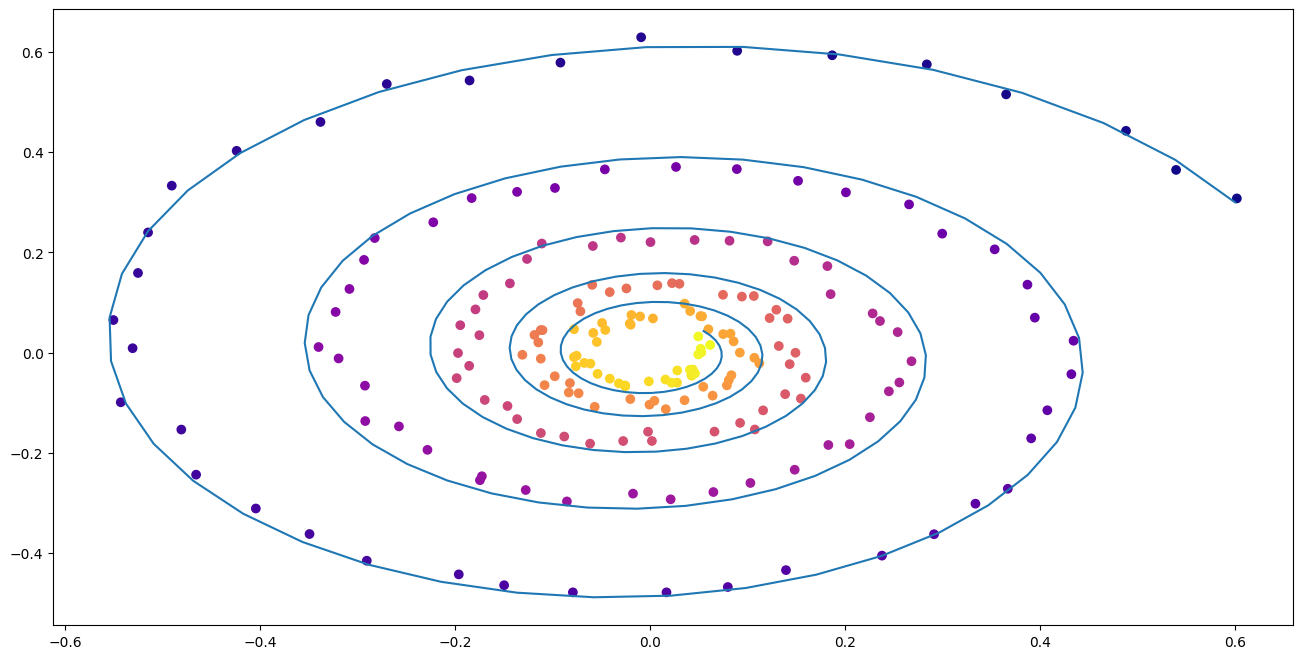

In [22]:
conduct_experiment(ode_true, ode_trained, 500, "linear")

In [ ]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func)

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)

In [ ]:
conduct_experiment(ode_true, ode_trained, 3000, "comp", plot_freq=30)

可以看出，神经 ODE 在近似动力学方面非常成功。现在，让我们来看看它们能否用于稍微复杂一点的任务（MNIST，哈哈）。

## Neural ODE inspired by ResNets 

在残差网络中，隐藏状态根据以下公式变化
$$
h_{t+1} = h_{t} + f(h_{t}, \theta_{t})
$$

其中，$t \in \{0...T\}$是残差块编号，$f$是块内各层学习到的函数。

如果我们以更小的步长对无穷多个残差块进行极限计算，就会得到隐藏单元的连续动态方程，就像我们上面提到的常微分方程一样。
$$
\frac{dh(t)}{dt} = f(h(t), t, \theta)
$$

从输入层 $h(0)$开始，我们可以定义输出层 $h(T)$ 为某个时间 T 的 ODE 初值问题的解。

现在，我们可以将 $\theta$ 视为所有无限小残差块共享的参数。

### 在 MNIST 上测试神经 ODE 架构

在本节中，我们将测试将神经 ODE 作为更传统架构中的一个组件的能力。 
特别是，我们将使用神经 ODE 代替 MNIST 分类器中的残差块。
<img src="assets/mnist_example.png" width=400></img>

In [28]:
def norm(dim):
    return nn.BatchNorm2d(dim) 
    #返回一个批量归一化层 BatchNorm2d，该层对每个通道单独进行归一化。批量归一化的作用是加速训练过程并稳定神经网络的收敛。

def conv3x3(in_feats, out_feats, stride=1):
    return nn.Conv2d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False)

def add_time(in_tensor, t): #该函数将时间变量 t 添加到输入张量 in_tensor 中，作为附加的通道
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1) #t 的形状为 (bs, 1, w, h)
    #最终的输出张量形状为 (bs, c + 1, w, h)，即在原来的 c 个通道上添加一个时间通道。

In [ ]:
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt

In [ ]:
class ContinuousNeuralMNISTClassifier(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeuralMNISTClassifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode #ode=NeuralODE(func)
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) #平均池化
        self.fc = nn.Linear(64, 10) 

    def forward(self, x):  # example(batch_size,1,28,28)
        x = self.downsampling(x) #(batch_size,1,28,28)->(batch_size,64,28,28)->(batch_size,64,14,14)->(batch_size,64,7,7)
        x = self.feature(x) #(batch_size,64,7,7)->(batch_size,64,7,7)
        x = self.norm(x)
        x = self.avg_pool(x) #(batch_size,64,7,7)->(batch_size,64,1,1)
        shape = torch.prod(torch.tensor(x.shape[1:])).item() #计算 x 的形状的乘积，即 64*1*1=64
        x = x.view(-1, shape) #将张量 x 展平为二维张量，形状为 (batch_size, shape)，以便送入全连接层
        out = self.fc(x) 
        return out

In [ ]:
func = ConvODEF(64)
ode = NeuralODE(func)
model = ContinuousNeuralMNISTClassifier(ode)
if use_cuda:
    model = model.cuda()

In [ ]:
import torchvision

img_std = 0.3081
img_mean = 0.1307


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=128, shuffle=True
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def train(epoch):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

In [ ]:
def test():
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [ ]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

In [ ]:
import pandas as pd

plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["cum_data"] = history.index * batch_size
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="cum_data", y="smooth_loss", figsize=(12, 5), title="train error")

```
Testing...
100% 79/79 [00:01<00:00, 45.69it/s]
Test Accuracy: 9.740%

Training Epoch 1...
100% 1875/1875 [01:15<00:00, 24.69it/s]
Train loss: 0.20137
Testing...
100% 79/79 [00:01<00:00, 46.64it/s]
Test Accuracy: 98.680%

Training Epoch 2...
100% 1875/1875 [01:17<00:00, 24.32it/s]
Train loss: 0.05059
Testing...
100% 79/79 [00:01<00:00, 46.11it/s]
Test Accuracy: 97.760%

Training Epoch 3...
100% 1875/1875 [01:16<00:00, 24.63it/s]
Train loss: 0.03808
Testing...
100% 79/79 [00:01<00:00, 45.65it/s]
Test Accuracy: 99.000%

Training Epoch 4...
100% 1875/1875 [01:17<00:00, 24.28it/s]
Train loss: 0.02894
Testing...
100% 79/79 [00:01<00:00, 45.42it/s]
Test Accuracy: 99.130%

Training Epoch 5...
100% 1875/1875 [01:16<00:00, 24.67it/s]
Train loss: 0.02424
Testing...
100% 79/79 [00:01<00:00, 45.89it/s]
Test Accuracy: 99.170%
```

![train error](assets/train_error.png)

在经过 5 个历元和 6 分钟的粗略训练后，模型的测试误差已经小于 1%。这表明，神经 ODE 架构非常适合作为更多传统网络的组成部分。

在他们的论文中，作者还将这种分类器与简单的单层 MLP、具有相同架构的 ResNet 以及相同的 ODE 架构（但梯度直接通过 ODESolve 传播，不使用梯度邻接法）（RK-Net）进行了比较。
!["Methods comparison"](assets/methods_compare.png)

<div align="center">Figure from original paper</div>

根据他们的研究，与神经 ODE-Net 的参数量大致相同的单层 MLP 的测试误差要大得多，误差大致相同的 ResNet 的参数量要大得多，而通过 ODESolver 直接反向传播的 RK-Net 的误差略高，内存使用量呈线性增长。

在他们的论文中，作者使用了具有自适应步长的隐式 Runge-Kutta 求解器，而不是简单的欧拉法。他们还研究了一些 ODE-Net 特性。
!["Node attrs"](assets/ode_solver_attrs.png)

<div align="center">ODE-Net 特性 (NFE Forward - 前向传递过程中的函数求值次数)</div>
<div align="center">Figure from original paper</div>

- (a) 改变可容忍的数值误差会改变每次前向传递评估的步数 
- (b) 前向调用所花费的时间与函数评估次数成正比 
- (c) 后向评估次数大约是前向评估次数的一半，这表明与通过 ODESolver 直接反向传播相比，邻接法的计算效率更高 
- (d) 随着 ODE-Net 训练得越来越多，它需要的评估次数也越来越多，这可能是为了适应模型复杂性的增加。

### 生成潜函数时间序列模型

神经 ODE 似乎更适合连续序列数据，即使这种连续轨迹是在某些未知的潜在空间中。

在本节中，我们将尝试使用神经 ODE 生成连续序列数据，并对其潜在空间进行一些探索。 作者还将其与使用循环神经网络生成的相同序列数据进行了比较。

这里的方法与作者存储库中的相应示例略有不同，这里的示例具有更多样化的轨迹集。

### Data

训练数据由随机螺旋组成，其中一半为顺时针方向，另一半为逆时针方向。然后，从这些螺旋中随机抽取大小为 100 的子时间段，以相反的顺序通过编码器 rnn 模型，产生一个潜在的起始状态，然后在潜在空间中形成一个轨迹。然后，该潜在轨迹被映射到数据空间轨迹上，并与实际数据观测结果进行比较。这样，模型就学会了生成与数据相似的轨迹。

![image.png](assets/spirals_examples.png)
<div align="center">Examples of spirals in the dataset</div>

### VAE as a generative model

通过采样序列生成模型
$$
z_{t_0} \sim \mathcal{N}(0, I)
$$

$$
z_{t_1}, z_{t_2},...,z_{t_M} = \text{ODESolve}(z_{t_0}, f, \theta_f, t_0,...,t_M)
$$

$$
\text{each } x_{t_i} \sim p(x \mid z_{t_i};\theta_x)
$$

可以使用变异自动编码器方法对其进行训练：

1. 通过时间倒序运行 RNN 编码器来推断变分后验的参数 $\mu_{z_{t_0}}$、$\sigma_{z_{t_0}}$，并从中采样
$$
z_{t_0} \sim q \left( z_{t_0} \mid x_{t_0},...,x_{t_M}; t_0,...,t_M; \theta_q \right) = \mathcal{N} \left(z_{t_0} \mid \mu_{z_{t_0}} \sigma_{z_{t_0}} \right)
$$
2. 获取潜在轨迹
$$
z_{t_1}, z_{t_2},...,z_{t_N} = \text{ODESolve}(z_{t_0}, f, \theta_f, t_0,...,t_N), \text{ where } \frac{d z}{d t} = f(z, t; \theta_f)
$$
3. 使用另一个神经网络将潜在轨迹映射到数据空间： $\hat{x_{t_i}}(z_{t_i}, t_i; \theta_x)$
4. 最大化取样轨迹的证据下限 BOund 估计值
$$
\text{ELBO} \approx N \Big( \sum_{i=0}^{M} \log p(x_{t_i} \mid z_{t_i}(z_{t_0}; \theta_f); \theta_x) + KL \left( q( z_{t_0} \mid x_{t_0},...,x_{t_M}; t_0,...,t_M; \theta_q) \parallel \mathcal{N}(0, I) \right) \Big)
$$
而在高斯后验 $p(x \mid z_{t_i};\theta_x)$ 和已知噪声水平 $\sigma_x$ 的情况下
$$
\text{ELBO} \approx -N \Big( \sum_{i=1}^{M}\frac{(x_i - \hat{x_i} )^2}{\sigma_x^2} - \log \sigma_{z_{t_0}}^2 + \mu_{z_{t_0}}^2 + \sigma_{z_{t_0}}^2 \Big) + C
$$

潜在 ODE 模型的计算图可以这样描述
![vae_model](assets/vae_model.png)
<div align="center">Figure from the original paper</div>

然后，我们就可以测试该模型如何仅根据其初始时刻观测结果推断出轨迹。

### 定义模型

In [4]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(RNNEncoder, self).__init__()
        self.input_dim = input_dim #输入特征
        self.hidden_dim = hidden_dim #隐藏层
        self.latent_dim = latent_dim #潜在空间维度

        self.rnn = nn.GRU(input_dim+1, hidden_dim) #GRU层将处理输入序列，输入维度为 input_dim + 1，其中 +1 是因为时间 t 被附加到输入特征上
        self.hid2lat = nn.Linear(hidden_dim, 2*latent_dim) #线性层，用于将隐藏状态转换为潜在空间的均值和对数方差，用于表示高斯分布

    def forward(self, x, t):
        # Concatenate time to input
        t = t.clone()
        t[1:] = t[:-1] - t[1:] #计算时间序列的时间差，将其转换为每一步的时间增量（时间步之间的差异）。这样做是为了使模型能够学习到时间序列的动态特性。
        t[0] = 0.#将第一个时间步的时间差设置为 0（通常这是初始点的时间）。
        xt = torch.cat((x, t), dim=-1) #将时间差 t 附加到输入 x 的最后一个维度上，形成一个新的输入张量 xt，包含输入特征和时间信息。
        #xt.flip((0,))将输入序列反转，时间顺序变成从最后一个时间步到第一个时间步，这样 GRU 就会从最后一个时间步处理到最前面的时间步。
        _, h0 = self.rnn(xt.flip((0,)))  #h0 是最后时间步的隐藏状态，_ 忽略所有时间步的输出（因为我们只关心最后的隐藏状态）。
        # Compute latent dimension
        z0 = self.hid2lat(h0[0]) 
        # 将 GRU 最后的隐藏状态 h0[0] 输入到线性层 hid2lat 中，得到一个维度为 2 * latent_dim 的输出 z0，其中前一半是潜在空间的均值，后一半是潜在空间的对数方差。
        z0_mean = z0[:, :self.latent_dim]
        z0_log_var = z0[:, self.latent_dim:]
        return z0_mean, z0_log_var

In [5]:
class NeuralODEDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(NeuralODEDecoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        func = NNODEF(latent_dim, hidden_dim, time_invariant=True) #  time_invariant=True表示与时间相关
        self.ode = NeuralODE(func)
        self.l2h = nn.Linear(latent_dim, hidden_dim)
        self.h2o = nn.Linear(hidden_dim, output_dim)

    def forward(self, z0, t):
        zs = self.ode(z0, t, return_whole_sequence=True)

        hs = self.l2h(zs)
        xs = self.h2o(hs)
        return xs

In [6]:
class ODEVAE(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(ODEVAE, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = RNNEncoder(output_dim, hidden_dim, latent_dim)
        self.decoder = NeuralODEDecoder(output_dim, hidden_dim, latent_dim)

    def forward(self, x, t, MAP=False):
        z_mean, z_log_var = self.encoder(x, t)
        if MAP: #MAP（最大后验概率）是一个标志。如果为 True，表示只使用潜在空间的均值 z_mean 来生成潜在变量 z，即不进行采样操作，直接取分布的均值作为潜在变量。
            z = z_mean
        else:
            z = z_mean + torch.randn_like(z_mean) * torch.exp(0.5 * z_log_var) #重参数法
        x_p = self.decoder(z, t)
        return x_p, z, z_mean, z_log_var

    def generate_with_seed(self, seed_x, t): #通过种子生成数据
        seed_t_len = seed_x.shape[0] #种子序列的长度
        z_mean, z_log_var = self.encoder(seed_x, t[:seed_t_len]) 
        #将种子序列 seed_x 和相应的时间序列 t[:seed_t_len] 输入编码器，获得潜在空间的均值和对数方差。
        x_p = self.decoder(z_mean, t) #使用编码器的均值 z_mean 作为潜在空间表示，并通过解码器 NeuralODEDecoder 生成新的时间序列数据 x_p
        return x_p

### 生成数据集

In [ ]:
t_max = 6.29*5
n_points = 200
noise_std = 0.02

num_spirals = 1000

index_np = np.arange(0, n_points, 1, dtype=np.int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]] * num_spirals)
times = torch.from_numpy(times_np[:, :, None]).to(torch.float32)

# Generate random spirals parameters
normal01 = torch.distributions.Normal(0, 1.0)

x0 = Variable(normal01.sample((num_spirals, 2))) * 2.0  

W11 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W22 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W21 = -1.0 * normal01.sample((num_spirals,)).abs()
W12 =  1.0 * normal01.sample((num_spirals,)).abs()

xs_list = []
for i in range(num_spirals):
    if i % 2 == 1: #  Make it counter-clockwise
        W21, W12 = W12, W21

    func = LinearODEF(Tensor([[W11[i], W12[i]], [W21[i], W22[i]]]))
    ode = NeuralODE(func)

    xs = ode(x0[i:i+1], times[:, i:i+1], return_whole_sequence=True)
    xs_list.append(xs)


orig_trajs = torch.cat(xs_list, dim=1).detach()
samp_trajs = orig_trajs + torch.randn_like(orig_trajs) * noise_std
samp_ts = times

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.scatter(samp_trajs[:, i, 0], samp_trajs[:, i, 1], c=samp_ts[:, i, 0], cmap=cm.plasma)
plt.show()

In [ ]:
import numpy.random as npr

def gen_batch(batch_size, n_sample=100):
    n_batches = samp_trajs.shape[1] // batch_size
    time_len = samp_trajs.shape[0]
    n_sample = min(n_sample, time_len)
    for i in range(n_batches):
        if n_sample > 0:
            t0_idx = npr.multinomial(1, [1. / (time_len - n_sample)] * (time_len - n_sample))
            t0_idx = np.argmax(t0_idx)
            tM_idx = t0_idx + n_sample
        else:
            t0_idx = 0
            tM_idx = time_len

        frm, to = batch_size*i, batch_size*(i+1)
        yield samp_trajs[t0_idx:tM_idx, frm:to], samp_ts[t0_idx:tM_idx, frm:to]

### Training

In [ ]:
vae = ODEVAE(2, 64, 6)
vae = vae.cuda()
if use_cuda:
    vae = vae.cuda()

In [ ]:
optim = torch.optim.Adam(vae.parameters(), betas=(0.9, 0.999), lr=0.001)

In [ ]:
preload = False
n_epochs = 20000
batch_size = 100

plot_traj_idx = 1
plot_traj = orig_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_obs = samp_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_ts = samp_ts[:, plot_traj_idx:plot_traj_idx+1]
if use_cuda:
    plot_traj = plot_traj.cuda()
    plot_obs = plot_obs.cuda()
    plot_ts = plot_ts.cuda()

if preload:
    vae.load_state_dict(torch.load("models/vae_spirals.sd"))

for epoch_idx in range(n_epochs):
    losses = []
    train_iter = gen_batch(batch_size)
    for x, t in train_iter:
        optim.zero_grad()
        if use_cuda:
            x, t = x.cuda(), t.cuda()

        max_len = np.random.choice([30, 50, 100])
        permutation = np.random.permutation(t.shape[0])
        np.random.shuffle(permutation)
        permutation = np.sort(permutation[:max_len])

        x, t = x[permutation], t[permutation]

        x_p, z, z_mean, z_log_var = vae(x, t)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), -1)
        loss = 0.5 * ((x-x_p)**2).sum(-1).sum(0) / noise_std**2 + kl_loss
        loss = torch.mean(loss)
        loss /= max_len
        loss.backward()
        optim.step()
        losses.append(loss.item())

    print(f"Epoch {epoch_idx}")

    frm, to, to_seed = 0, 200, 50
    seed_trajs = samp_trajs[frm:to_seed]
    ts = samp_ts[frm:to]
    if use_cuda:
        seed_trajs = seed_trajs.cuda()
        ts = ts.cuda()

    samp_trajs_p = to_np(vae.generate_with_seed(seed_trajs, ts))

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.scatter(to_np(seed_trajs[:, i, 0]), to_np(seed_trajs[:, i, 1]), c=to_np(ts[frm:to_seed, i, 0]), cmap=cm.plasma)
        ax.plot(to_np(orig_trajs[frm:to, i, 0]), to_np(orig_trajs[frm:to, i, 1]))
        ax.plot(samp_trajs_p[:, i, 0], samp_trajs_p[:, i, 1])
    plt.show()

    print(np.mean(losses), np.median(losses))
    clear_output(wait=True)

In [ ]:
spiral_0_idx = 3
spiral_1_idx = 6

homotopy_p = Tensor(np.linspace(0., 1., 10)[:, None])
vae = vae
if use_cuda:
    homotopy_p = homotopy_p.cuda()
    vae = vae.cuda()

spiral_0 = orig_trajs[:, spiral_0_idx:spiral_0_idx+1, :]
spiral_1 = orig_trajs[:, spiral_1_idx:spiral_1_idx+1, :]
ts_0 = samp_ts[:, spiral_0_idx:spiral_0_idx+1, :]
ts_1 = samp_ts[:, spiral_1_idx:spiral_1_idx+1, :]
if use_cuda:
    spiral_0, ts_0 = spiral_0.cuda(), ts_0.cuda()
    spiral_1, ts_1 = spiral_1.cuda(), ts_1.cuda()

z_cw, _ = vae.encoder(spiral_0, ts_0)
z_cc, _ = vae.encoder(spiral_1, ts_1)

homotopy_z = z_cw * (1 - homotopy_p) + z_cc * homotopy_p

t = torch.from_numpy(np.linspace(0, 6*np.pi, 200))
t = t[:, None].expand(200, 10)[:, :, None].cuda()
t = t.cuda() if use_cuda else t
hom_gen_trajs = vae.decoder(homotopy_z, t)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.plot(to_np(hom_gen_trajs[:, i, 0]), to_np(hom_gen_trajs[:, i, 1]))
plt.show()

这是我经过一夜训练后得到的结果
![spiral reconstruction with seed](assets/spirals_reconstructed.png)
<div align="center">点为原始轨迹的噪声观测值（蓝色） <br /> 黄色是以点为输入的重建和内插轨迹。 <br /> 点的颜色代表时间。 </div>

某些示例的重构效果不是很好。可能是模型不够复杂，也可能是训练时间不够长。总之，结果看起来非常可信。

现在让我们看看，如果我们将顺时针轨迹的潜变量插值到另一个轨迹（逆时针轨迹）上，会发生什么情况。
![homotopy](assets/spirals_homotopy.png)

作者还比较了使用神经 ODE 和简单 RNN 的初始时刻时间观测重建的轨迹。
![ode_rnn_comp](assets/ode_rnn_comp.png)
<div align="center">Figure from the original paper</div>

## 连续正常化流量

原论文在 "归一化流量 "方面也有很多贡献。归一化流量用于需要从复杂分布中采样的情况，复杂分布源自某个简单分布（如高斯分布）中的变量变化，同时仍能知道每个样本的概率密度。  
他们的研究表明，使用连续变量变化的方法比以前的方法更具有计算效率和可解释性。

归一化流在*变量自动编码器*、*贝叶斯神经网络*等贝叶斯模型中非常有用。

不过，这个话题超出了本笔记本的讨论范围，感兴趣的读者可参阅原论文。

逗你一乐
![CNF_NF_comp](assets/CNF_NF_comp.png)

<div align="center">可视化两个数据集从噪声（简单分布）到数据（复杂分布）的转换；<br /> X 轴代表密度和样本转换，"时间"（CNF）和 "深度"（NF）代表密度和样本转换 <br />Figure from the original paper</div>

至此，我对**神经 ODE**的小研究告一段落。希望对你有用！

# Useful links

   - [Original paper](https://arxiv.org/abs/1806.07366)
   - [Authors' PyTorch implementation](https://github.com/rtqichen/torchdiffeq)
   - [Variational Inference](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf)
   - [My article on VAE (Russian)](https://habr.com/en/post/331552/)
   - [VAE explained](https://www.jeremyjordan.me/variational-autoencoders/)
   - [More on Normalizing Flows](http://akosiorek.github.io/ml/2018/04/03/norm_flows.html)
   - [Variational Inference with Normalizing Flows Paper](https://arxiv.org/abs/1505.05770)